In [20]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Chargement et correction des données

Ce dataset est utilisé pour effectuer la prédiction de la température d'une pièce en fonction de plusieurs paramètres mesurés. La fréquence originale des données est d'une minute, puis a été modifiée à 15minutes avec un filtrage. L'ensemble correspond environ à une durée de 40 jours.  
Nous allons utiliser ici la température de la chambre comme cible et sélectionner 18 séries exogènes. 

**1. Chargement des données**

In [21]:
!rm *.txt
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/NEW-DATA-1.T15.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   181  100   181    0     0    726      0 --:--:-- --:--:-- --:--:--   726
100  386k  100  386k    0     0   798k      0 --:--:-- --:--:-- --:--:-- 13.4M


**2. Analyse et correction des données**

In [22]:
# Création de la série sous Pandas
df_etude = pd.read_csv("NEW-DATA-1.T15.txt",sep=" ")
df_etude

,Date,Time,Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0000,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,0,0,0,18.1150,48.3750,2.0
1,13/03/2012,12:00,18.4633,18.1207,6.8000,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,0,0,0,18.4147,47.8080,2.0
2,13/03/2012,12:15,18.7673,18.4367,17.0000,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,0,0,0,18.8533,47.4320,2.0
3,13/03/2012,12:30,19.0727,18.7513,18.0000,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,0,0,0,19.2907,47.0240,2.0
4,13/03/2012,12:45,19.3721,19.0414,20.0000,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,0,0,0,19.7400,45.4743,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,11/04/2012,05:30,21.1520,20.8187,13.0000,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,0,0,0,16.6180,49.2960,3.0
2760,11/04/2012,05:45,21.0413,20.7053,12.1333,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,0,0,0,16.4013,50.0373,3.0
2761,11/04/2012,06:00,20.9347,20.5827,12.0000,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,0,0,0,16.2607,50.0587,3.0
2762,11/04/2012,06:15,20.8560,20.5200,12.0000,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,0,0,0,16.2367,49.8400,3.0


Supprime les colonnes non utiles :
 - Date et heure
 - Exterior Entalpic 1, 2 et turbo  
   
Déplace la cible (4:Temperature_Habitacion_Sensor) en dernière colonne :

In [23]:
df_etude = df_etude.drop(['Date','Time','19:Exterior_Entalpic_1', '20:Exterior_Entalpic_2', '21:Exterior_Entalpic_turbo'],axis=1)
cible = df_etude.pop("4:Temperature_Habitacion_Sensor")
df_etude.insert(len(df_etude.columns),"Temperature_Habitacion_Sensor",cible)
df_etude

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week,Temperature_Habitacion_Sensor
0,18.1875,0.0000,216.560,221.920,39.9125,42.4150,81.6650,113.5200,0.0,623.360,1.426250,9690.24,12604.20,95436.800,758.8800,18.1150,48.3750,2.0,17.8275
1,18.4633,6.8000,219.947,220.363,39.9267,42.2453,81.7413,113.6050,0.0,623.211,1.592000,11022.00,10787.20,95436.800,762.0690,18.4147,47.8080,2.0,18.1207
2,18.7673,17.0000,219.403,218.933,39.7720,42.2267,81.4240,113.6000,0.0,622.656,1.891330,13960.50,9669.63,95398.600,766.2510,18.8533,47.4320,2.0,18.4367
3,19.0727,18.0000,218.613,217.045,39.7760,42.0987,81.5013,113.3440,0.0,622.571,1.828000,18511.20,9648.13,95360.300,766.0370,19.2907,47.0240,2.0,18.7513
4,19.3721,20.0000,217.714,216.080,39.7757,42.0686,81.4657,113.0340,0.0,622.400,2.360710,26349.00,9208.32,95354.900,762.7430,19.7400,45.4743,2.0,19.0414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.1520,13.0000,190.539,192.181,41.3120,41.6880,11.4427,12.9400,0.0,392.603,0.074667,0.00,0.00,0.000,-3.4340,16.6180,49.2960,3.0,20.8187
2760,21.0413,12.1333,190.421,193.067,41.3173,41.7200,11.6867,19.3200,0.0,613.120,0.000000,465.92,2716.67,523.264,3.8520,16.4013,50.0373,3.0,20.7053
2761,20.9347,12.0000,190.432,193.653,41.3333,41.7573,19.5387,23.2427,0.0,613.803,0.310667,3454.98,16203.80,3347.460,26.8300,16.2607,50.0587,3.0,20.5827
2762,20.8560,12.0000,191.531,193.387,41.3093,41.8107,20.9853,23.4400,0.0,615.403,0.299333,6795.26,38303.10,7110.660,66.9493,16.2367,49.8400,3.0,20.5200


Affiche les types :

In [24]:
df_etude.dtypes

Temperature_Comedor_Sensor        float64
5:Weather_Temperature             float64
6:CO2_Comedor_Sensor              float64
7:CO2_Habitacion_Sensor           float64
8:Humedad_Comedor_Sensor          float64
9:Humedad_Habitacion_Sensor       float64
10:Lighting_Comedor_Sensor        float64
11:Lighting_Habitacion_Sensor     float64
12:Precipitacion                  float64
13:Meteo_Exterior_Crepusculo      float64
14:Meteo_Exterior_Viento          float64
15:Meteo_Exterior_Sol_Oest        float64
16:Meteo_Exterior_Sol_Est         float64
17:Meteo_Exterior_Sol_Sud         float64
18:Meteo_Exterior_Piranometro     float64
22:Temperature_Exterior_Sensor    float64
23:Humedad_Exterior_Sensor        float64
24:Day_Of_Week                    float64
Temperature_Habitacion_Sensor     float64
dtype: object

Modifie les type en float32 :

In [25]:
df_etude = df_etude.astype(dtype='float32')
df_etude.dtypes

Temperature_Comedor_Sensor        float32
5:Weather_Temperature             float32
6:CO2_Comedor_Sensor              float32
7:CO2_Habitacion_Sensor           float32
8:Humedad_Comedor_Sensor          float32
9:Humedad_Habitacion_Sensor       float32
10:Lighting_Comedor_Sensor        float32
11:Lighting_Habitacion_Sensor     float32
12:Precipitacion                  float32
13:Meteo_Exterior_Crepusculo      float32
14:Meteo_Exterior_Viento          float32
15:Meteo_Exterior_Sol_Oest        float32
16:Meteo_Exterior_Sol_Est         float32
17:Meteo_Exterior_Sol_Sud         float32
18:Meteo_Exterior_Piranometro     float32
22:Temperature_Exterior_Sensor    float32
23:Humedad_Exterior_Sensor        float32
24:Day_Of_Week                    float32
Temperature_Habitacion_Sensor     float32
dtype: object

**5. Affiche les données**

In [26]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['Temperature_Habitacion_Sensor'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Corrélations entre les variables

**1. Corrélation de l'ensemble des variables**

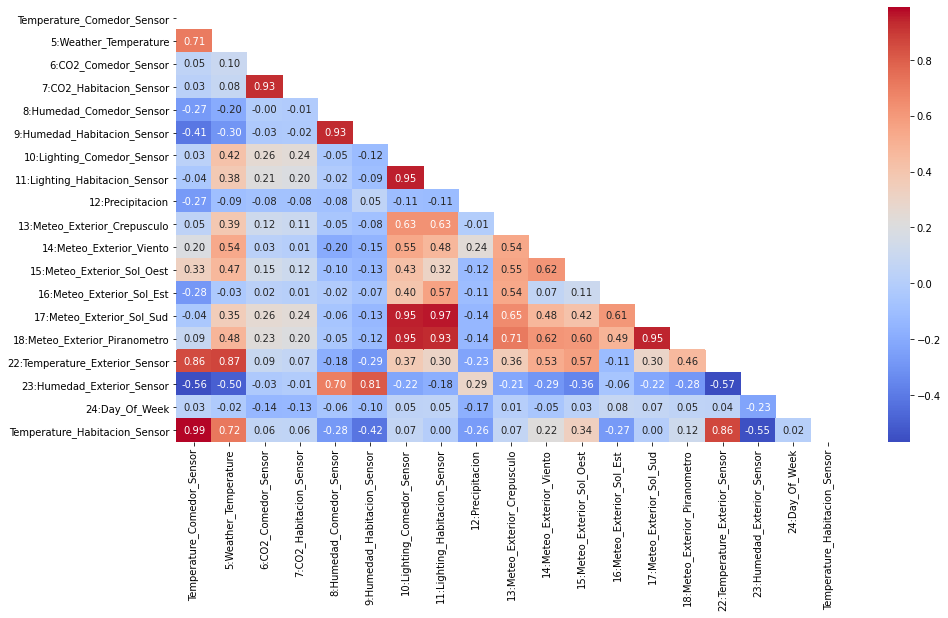

In [27]:
import seaborn as sns

corr = df_etude.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

# Choix des paramètres de l'algorithme Random Forest

Nous allons utiliser l'algorithme Random Forest intégré dans le package Scikit-Learn : [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) 

**1. Création des données X et Y**

In [30]:
X = df_etude.iloc[:,0:-1]
X

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,18.187500,0.0000,216.559998,221.919998,39.912498,42.415001,81.665001,113.519997,0.0,623.359985,1.426250,9690.240234,12604.200195,95436.796875,758.880005,18.115000,48.375000,2.0
1,18.463301,6.8000,219.947006,220.363007,39.926701,42.245300,81.741302,113.605003,0.0,623.210999,1.592000,11022.000000,10787.200195,95436.796875,762.068970,18.414700,47.807999,2.0
2,18.767300,17.0000,219.403000,218.932999,39.771999,42.226700,81.424004,113.599998,0.0,622.656006,1.891330,13960.500000,9669.629883,95398.601562,766.250977,18.853300,47.431999,2.0
3,19.072701,18.0000,218.613007,217.044998,39.776001,42.098701,81.501297,113.344002,0.0,622.570984,1.828000,18511.199219,9648.129883,95360.296875,766.036987,19.290701,47.023998,2.0
4,19.372101,20.0000,217.714005,216.080002,39.775700,42.068600,81.465698,113.033997,0.0,622.400024,2.360710,26349.000000,9208.320312,95354.898438,762.742981,19.740000,45.474300,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.152000,13.0000,190.539001,192.181000,41.312000,41.688000,11.442700,12.940000,0.0,392.602997,0.074667,0.000000,0.000000,0.000000,-3.434000,16.618000,49.296001,3.0
2760,21.041300,12.1333,190.421005,193.067001,41.317299,41.720001,11.686700,19.320000,0.0,613.119995,0.000000,465.920013,2716.669922,523.263977,3.852000,16.401300,50.037300,3.0
2761,20.934700,12.0000,190.432007,193.653000,41.333302,41.757301,19.538700,23.242701,0.0,613.802979,0.310667,3454.979980,16203.799805,3347.459961,26.830000,16.260700,50.058701,3.0
2762,20.856001,12.0000,191.531006,193.386993,41.309299,41.810699,20.985300,23.440001,0.0,615.403015,0.299333,6795.259766,38303.101562,7110.660156,66.949303,16.236700,49.840000,3.0


In [31]:
Y = df_etude.iloc[:,-1:]
Y

,Temperature_Habitacion_Sensor
0,17.827499
1,18.120701
2,18.436701
3,18.751301
4,19.041401
...,...
2759,20.818701
2760,20.705299
2761,20.582701
2762,20.520000


**2. Choix du nombre d'arbres**

Parmi les paramètres de l'algorithme [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) nous trouvons :
 - **n_estimators** : C'est le nombre d'arbres utilisés
 - **bootstrap** : Choix d'utiliser ou non la méthode du bootstrap pour construire les arbres. Si le bootstrap n'est pas activé, tous les arbres seront constuits avec le même dataset.  
 - **oob_score** : Choix d'utiliser les échantillons out-of-bag pour calculer le score moyen des prédictions (uniquement utilisable si l'option bootstrap est activée)
 - **max_sample** : Si le bootstrap est activé, permet de choisir le nombre d'échantillons à prendre dans le dataset initial pour construire chaque estimateur.  
 - **max_features** : Le nombre de données prises aléatoirement pour découper découper un noeud de l'arbre (mtry)  

On commence par regarder comment évolue le score de l'OOB sur une 40ène d'essais avec un nombre d'arbres croissant, tout en gardant une valeur de mtry par défaut (racine carrée du nombre de variables en classification et nombre de variables divisé par 3 en régression). On choisira le nombre d'arbre tel qu'il soit minimal et que le score OOB soit stabilisé.  

In [ ]:
# Informations sur les données
n = 2764              # Nombre d'observations
p = 18                # Nombre de variables

n_arbres_max = 5000

n_arbres = np.linspace(50,n_arbres_max,40).astype(np.int32)
mtry = p/3
OOB_err = []

for i in n_arbres:
  print("#Arbres : %d" %i)
  clf = RandomForestRegressor(n_estimators=i, bootstrap=True, oob_score=True, max_samples = n, max_features = p, n_jobs=-1)
  clf.fit(X,tf.squeeze(np.asarray(Y),1))
  OOB_err.append(1 - clf.oob_score_)

In [ ]:
plt.plot(n_arbres,OOB_err)

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/SML_narbres.png?raw=true" width=400>

**3. Choix du mtry**

On regarde comment évolue le score de l'OOB sur une 10ène d'essais avec un nombre d'arbres fixé à la valeur trouvée précédemment, puis en faisant varier la valeur de mtry de la moitié de sa valeur par défaut jusqu'à son maximum possible. On choisira la valeur de mtry telle qu'elle soit minimale et que le score OOB soit stabilisé.  

In [53]:
# Informations sur les données
n = 2764              # Nombre d'observations
p = 18                # Nombre de variables

n_arbres = 3000
mtry_0 = np.int32(0.5*(p/3))

m_try = np.linspace(mtry_0,p,10).astype(np.int32)

OOB_err = []

for i in m_try:
   print("mtry = %s" %i)
   clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=i, n_jobs=-1)
   clf.fit(X,tf.squeeze(np.asarray(Y),1))
   OOB_err.append(1 - clf.oob_score_)

mtry = 3
mtry = 4
mtry = 6
mtry = 8
mtry = 9
mtry = 11
mtry = 13
mtry = 14
mtry = 16
mtry = 18


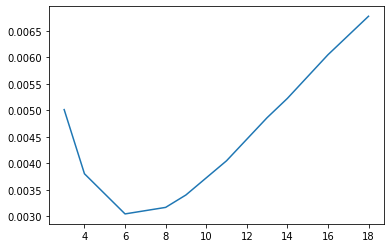

In [55]:
plt.plot(m_try,OOB_err)

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/SML_ntry.png?raw=true" width=400>

On choisir n_arbres = 3000 et on utilise m_try = 6

# Importance des variables : Importance sans permutations (Gini Importance)

**1. Entrainement de la forêt**

In [56]:
from sklearn.inspection import permutation_importance

# Informations sur les données
n = 2764             # Nombre d'observations
p = 18               # Nombre de variables
n_arbres = 3000
m_try = 6

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
clf.fit(X,tf.squeeze(np.asarray(Y),1))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=3000, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

**2. Affichage de l'importance des variables**

In [125]:
col_sorted_by_importance=np.argsort(-clf.feature_importances_)

feat_imp = pd.DataFrame({'cols':X.columns[col_sorted_by_importance],'imps':clf.feature_importances_[col_sorted_by_importance]})
feat_imp

,cols,imps
0,Temperature_Comedor_Sensor,0.496620
1,22:Temperature_Exterior_Sensor,0.234812
2,5:Weather_Temperature,0.092995
3,23:Humedad_Exterior_Sensor,0.048971
4,9:Humedad_Habitacion_Sensor,0.036998
5,18:Meteo_Exterior_Piranometro,0.014368
6,8:Humedad_Comedor_Sensor,0.012479
7,15:Meteo_Exterior_Sol_Oest,0.010798
8,16:Meteo_Exterior_Sol_Est,0.007725
9,7:CO2_Habitacion_Sensor,0.007597


In [58]:
!pip install plotly_express --upgrade -q

In [66]:
import plotly_express as px
import plotly.offline as po

px.bar(feat_imp.sort_values(['imps'], ascending=False)[:30], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/SML_GiniImportance.png?raw=true">

# Importance des variables - Méthode par permutations

Le calcul de l'importance par la méthode des permutations est une technique dans laquelle on mélange les valeurs d'une colonne afin d'observer l'impact sur le score obtenu. Si le score est beaucoup affecté, cela signifie que la variable permutée est très importante.

On utilise la méthode de Scikit-learn [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

In [108]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X, Y, n_repeats=10,n_jobs=-1)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [109]:
result

{'importances': array([[7.46126137e-01, 7.67213335e-01, 7.43748185e-01, 7.78743274e-01,
         7.74118092e-01, 7.59168132e-01, 7.63404127e-01, 7.76936329e-01,
         7.72114985e-01, 7.69490957e-01],
        [1.36652239e-02, 1.43431945e-02, 1.28864875e-02, 1.51099792e-02,
         1.46999372e-02, 1.40659517e-02, 1.44381146e-02, 1.44792062e-02,
         1.42470422e-02, 1.47474339e-02],
        [1.19784348e-03, 1.28112040e-03, 1.24852395e-03, 1.24420018e-03,
         1.27376631e-03, 1.26449657e-03, 1.19767352e-03, 1.25377697e-03,
         1.26441376e-03, 1.27285831e-03],
        [2.23734262e-03, 2.27898490e-03, 2.23858736e-03, 2.22821995e-03,
         2.44561035e-03, 2.25476323e-03, 2.12920269e-03, 2.31312125e-03,
         2.32691445e-03, 2.32708663e-03],
        [3.10346142e-03, 2.99393881e-03, 3.12282267e-03, 3.10640472e-03,
         3.29161824e-03, 2.97740297e-03, 3.08884726e-03, 2.98443667e-03,
         3.17760428e-03, 2.93000252e-03],
        [1.33086944e-02, 1.39281742e-02, 1.33

In [110]:
scores={c:[] for c in X.columns}
i=0
for c in scores:
  scores[c].append(result.importances_mean[i])
  i = i+1

In [111]:
scores

{'10:Lighting_Comedor_Sensor': [0.0005132415671047719],
 '11:Lighting_Habitacion_Sensor': [0.0006536888259536244],
 '12:Precipitacion': [0.00015273292508223292],
 '13:Meteo_Exterior_Crepusculo': [0.0005104331402294715],
 '14:Meteo_Exterior_Viento': [0.00039424213654379867],
 '15:Meteo_Exterior_Sol_Oest': [0.0005732755173212256],
 '16:Meteo_Exterior_Sol_Est': [0.0007720812407348787],
 '17:Meteo_Exterior_Sol_Sud': [0.0005328778716860993],
 '18:Meteo_Exterior_Piranometro': [0.0009919940269450755],
 '22:Temperature_Exterior_Sensor': [0.1163636864953981],
 '23:Humedad_Exterior_Sensor': [0.005815886415664417],
 '24:Day_Of_Week': [0.0011014620348922754],
 '5:Weather_Temperature': [0.01426825708208227],
 '6:CO2_Comedor_Sensor': [0.0012498673440870522],
 '7:CO2_Habitacion_Sensor': [0.002277983343696588],
 '8:Humedad_Comedor_Sensor': [0.003077653957593807],
 '9:Humedad_Habitacion_Sensor': [0.013705794476788302],
 'Temperature_Comedor_Sensor': [0.7651063552679142]}

In [112]:
pd.DataFrame.from_dict(scores).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)

,variable,value
17,Temperature_Comedor_Sensor,0.765106
9,22:Temperature_Exterior_Sensor,0.116364
12,5:Weather_Temperature,0.014268
16,9:Humedad_Habitacion_Sensor,0.013706
10,23:Humedad_Exterior_Sensor,0.005816
15,8:Humedad_Comedor_Sensor,0.003078
14,7:CO2_Habitacion_Sensor,0.002278
13,6:CO2_Comedor_Sensor,0.001250
11,24:Day_Of_Week,0.001101
8,18:Meteo_Exterior_Piranometro,0.000992


In [113]:
px.bar(
    pd.DataFrame.from_dict(scores).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False),
    x='variable',y='value',labels={'variable':'column','value':'% change in recall'})

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/SML_PermImportance.png?raw=true">

# Comparaison entre les deux méthodes

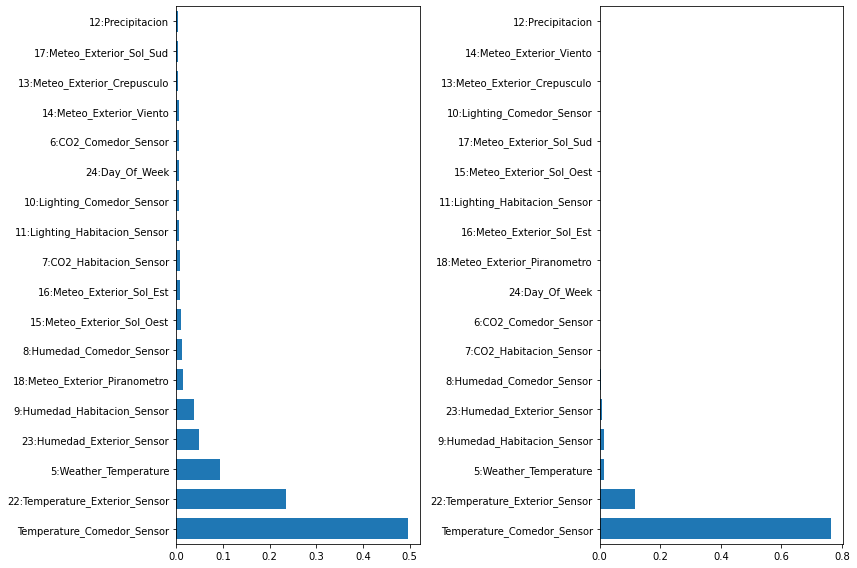

In [138]:
feature_perm = pd.DataFrame.from_dict(scores).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp

tree_indices = np.arange(0, len(feature_imp)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices,feature_imp['imps'].values, height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_imp['cols'].values)
ax1.set_ylim((0, len(feature_imp)))

ax2.barh(tree_indices,feature_perm['value'].values, height=0.7)
ax2.set_yticks(tree_indices)
ax2.set_yticklabels(feature_perm['variable'].values)
ax2.set_ylim((0, len(feature_perm)))

fig.tight_layout()
plt.show()

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/SML_CompImportance.png?raw=true">

# Sélection des variables par méthode RFE-CV

On utilise la méthode [RFE-CV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) afin de venir sélectionner les variables.

In [148]:
from sklearn.feature_selection import RFECV

# Informations sur les données
n = 2764             # Nombre d'observations
p = 18               # Nombre de variables
n_arbres = 3000
m_try = 6
min_features_to_select = 6

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features="auto", n_jobs=-1)
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='neg_mean_absolute_error',min_features_to_select=min_features_to_select, verbose=1)
rfecv.fit(X, tf.squeeze(np.asarray(Y),1))

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features

RFECV(cv=5,
      estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=3000, n_jobs=-1,
                                      oob_score=True, random_state=None,
                                      verbose=0, warm_start=False),
      min_features_to_select=6, n_jobs=None, scoring='neg_mean_absolute_error',
      step=1, verbose=1)

Optimal number of features : 14


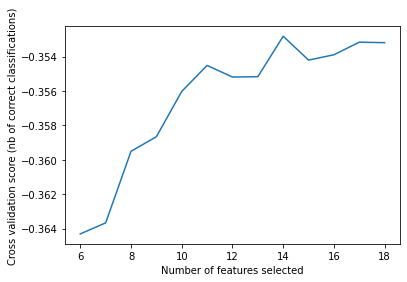

In [151]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

<img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/SML_RFECV.png?raw=true" width=400>

In [153]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 4, 1, 1, 1, 3, 1, 2, 1])

array([1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 4, 1, 1, 1, 3, 1, 2, 1])

In [154]:
selected = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 4, 1, 1, 1, 3, 1, 2, 1])
df_selected = pd.DataFrame()

for i in range(len(X.columns)):
  if selected[i] == 1:
    df_selected[X.columns[i]] = X[X.columns[i]]

df_selected

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,13:Meteo_Exterior_Crepusculo,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,22:Temperature_Exterior_Sensor,24:Day_Of_Week
0,18.187500,0.0000,216.559998,221.919998,39.912498,42.415001,81.665001,113.519997,623.359985,9690.240234,12604.200195,95436.796875,18.115000,2.0
1,18.463301,6.8000,219.947006,220.363007,39.926701,42.245300,81.741302,113.605003,623.210999,11022.000000,10787.200195,95436.796875,18.414700,2.0
2,18.767300,17.0000,219.403000,218.932999,39.771999,42.226700,81.424004,113.599998,622.656006,13960.500000,9669.629883,95398.601562,18.853300,2.0
3,19.072701,18.0000,218.613007,217.044998,39.776001,42.098701,81.501297,113.344002,622.570984,18511.199219,9648.129883,95360.296875,19.290701,2.0
4,19.372101,20.0000,217.714005,216.080002,39.775700,42.068600,81.465698,113.033997,622.400024,26349.000000,9208.320312,95354.898438,19.740000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.152000,13.0000,190.539001,192.181000,41.312000,41.688000,11.442700,12.940000,392.602997,0.000000,0.000000,0.000000,16.618000,3.0
2760,21.041300,12.1333,190.421005,193.067001,41.317299,41.720001,11.686700,19.320000,613.119995,465.920013,2716.669922,523.263977,16.401300,3.0
2761,20.934700,12.0000,190.432007,193.653000,41.333302,41.757301,19.538700,23.242701,613.802979,3454.979980,16203.799805,3347.459961,16.260700,3.0
2762,20.856001,12.0000,191.531006,193.386993,41.309299,41.810699,20.985300,23.440001,615.403015,6795.259766,38303.101562,7110.660156,16.236700,3.0


**Corrélation entre les variables**

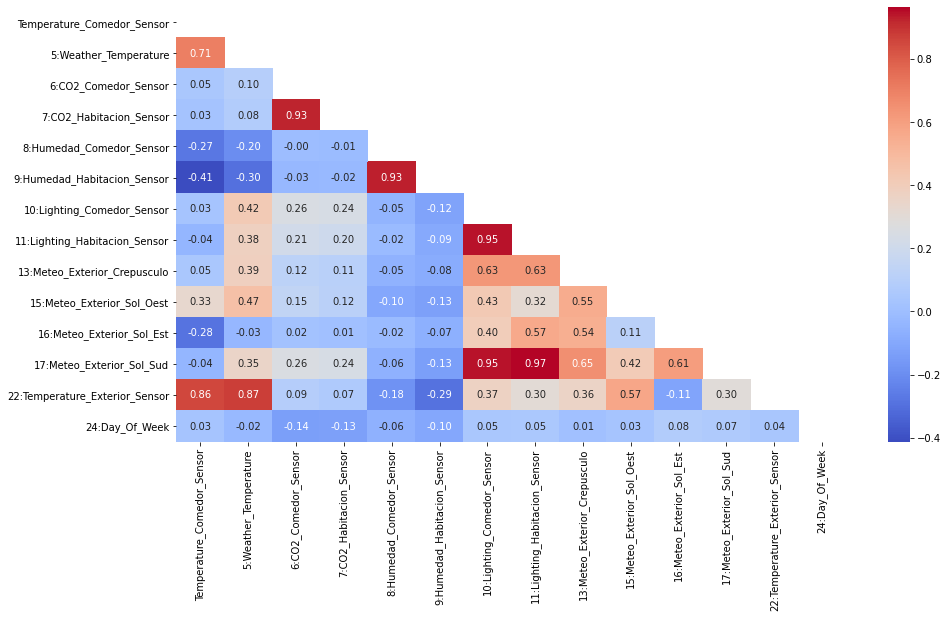

In [155]:
import seaborn as sns

corr = df_selected.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

**Exportation du dataframe :**

In [156]:
df_selected.insert(len(df_selected.columns),"Temperature_Habitacion_Sensor",cible)


In [157]:
df_selected

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,13:Meteo_Exterior_Crepusculo,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,22:Temperature_Exterior_Sensor,24:Day_Of_Week,Temperature_Habitacion_Sensor
0,18.187500,0.0000,216.559998,221.919998,39.912498,42.415001,81.665001,113.519997,623.359985,9690.240234,12604.200195,95436.796875,18.115000,2.0,17.8275
1,18.463301,6.8000,219.947006,220.363007,39.926701,42.245300,81.741302,113.605003,623.210999,11022.000000,10787.200195,95436.796875,18.414700,2.0,18.1207
2,18.767300,17.0000,219.403000,218.932999,39.771999,42.226700,81.424004,113.599998,622.656006,13960.500000,9669.629883,95398.601562,18.853300,2.0,18.4367
3,19.072701,18.0000,218.613007,217.044998,39.776001,42.098701,81.501297,113.344002,622.570984,18511.199219,9648.129883,95360.296875,19.290701,2.0,18.7513
4,19.372101,20.0000,217.714005,216.080002,39.775700,42.068600,81.465698,113.033997,622.400024,26349.000000,9208.320312,95354.898438,19.740000,2.0,19.0414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.152000,13.0000,190.539001,192.181000,41.312000,41.688000,11.442700,12.940000,392.602997,0.000000,0.000000,0.000000,16.618000,3.0,20.8187
2760,21.041300,12.1333,190.421005,193.067001,41.317299,41.720001,11.686700,19.320000,613.119995,465.920013,2716.669922,523.263977,16.401300,3.0,20.7053
2761,20.934700,12.0000,190.432007,193.653000,41.333302,41.757301,19.538700,23.242701,613.802979,3454.979980,16203.799805,3347.459961,16.260700,3.0,20.5827
2762,20.856001,12.0000,191.531006,193.386993,41.309299,41.810699,20.985300,23.440001,615.403015,6795.259766,38303.101562,7110.660156,16.236700,3.0,20.5200


In [158]:
from google.colab import files

df_selected.to_csv("SML2010_RFE-CV.csv")
files.download("SML2010_RFE-CV.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Extraction des données pour VSURF

**1. Extraction des données**

In [ ]:
X = df_etude.iloc[:,:-1]
X

,Temperature_Comedor_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,18.187500,0.0000,216.559998,221.919998,39.912498,42.415001,81.665001,113.519997,0.0,623.359985,1.426250,9690.240234,12604.200195,95436.796875,758.880005,18.115000,48.375000,2.0
1,18.463301,6.8000,219.947006,220.363007,39.926701,42.245300,81.741302,113.605003,0.0,623.210999,1.592000,11022.000000,10787.200195,95436.796875,762.068970,18.414700,47.807999,2.0
2,18.767300,17.0000,219.403000,218.932999,39.771999,42.226700,81.424004,113.599998,0.0,622.656006,1.891330,13960.500000,9669.629883,95398.601562,766.250977,18.853300,47.431999,2.0
3,19.072701,18.0000,218.613007,217.044998,39.776001,42.098701,81.501297,113.344002,0.0,622.570984,1.828000,18511.199219,9648.129883,95360.296875,766.036987,19.290701,47.023998,2.0
4,19.372101,20.0000,217.714005,216.080002,39.775700,42.068600,81.465698,113.033997,0.0,622.400024,2.360710,26349.000000,9208.320312,95354.898438,762.742981,19.740000,45.474300,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,21.152000,13.0000,190.539001,192.181000,41.312000,41.688000,11.442700,12.940000,0.0,392.602997,0.074667,0.000000,0.000000,0.000000,-3.434000,16.618000,49.296001,3.0
2760,21.041300,12.1333,190.421005,193.067001,41.317299,41.720001,11.686700,19.320000,0.0,613.119995,0.000000,465.920013,2716.669922,523.263977,3.852000,16.401300,50.037300,3.0
2761,20.934700,12.0000,190.432007,193.653000,41.333302,41.757301,19.538700,23.242701,0.0,613.802979,0.310667,3454.979980,16203.799805,3347.459961,26.830000,16.260700,50.058701,3.0
2762,20.856001,12.0000,191.531006,193.386993,41.309299,41.810699,20.985300,23.440001,0.0,615.403015,0.299333,6795.259766,38303.101562,7110.660156,66.949303,16.236700,49.840000,3.0


In [ ]:
Y = df_etude.iloc[:,-1:]
Y

,Temperature_Habitacion_Sensor
0,17.827499
1,18.120701
2,18.436701
3,18.751301
4,19.041401
...,...
2759,20.818701
2760,20.705299
2761,20.582701
2762,20.520000


In [ ]:
from google.colab import files

X.to_csv("X.csv")
Y.to_csv("Y.csv")

files.download("X.csv")
files.download("Y.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**2. Résultats**

Résultats :

> print(rsult$varselect.thres)  
 [1]  1  4  2  6 16 18  3 12 10  5 17  8 13  7 15 11 14

> print(rsult$varselect.interp)  
 [1]  1  4  2  6 16 18  3 12 10  5 17

> print(rsult$varselect.pred)  
[1] 1 4 2 6

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/VSURF_SML.png?raw=true' width=800>

**3. Création du dataframe**

In [ ]:
selected_pred = np.asarray([1,4,2,6])
selected_VSURF_pred = pd.DataFrame()

for i in range(len(selected_pred)):
    selected_VSURF_pred[X.columns[selected_pred[i]-1]] = X[X.columns[selected_pred[i]-1]]

selected_VSURF_pred['Temperature_Habitacion_Sensor'] = Y['Temperature_Habitacion_Sensor']
selected_VSURF_pred

,Temperature_Comedor_Sensor,7:CO2_Habitacion_Sensor,5:Weather_Temperature,9:Humedad_Habitacion_Sensor,Temperature_Habitacion_Sensor
0,18.187500,221.919998,0.0000,42.415001,17.827499
1,18.463301,220.363007,6.8000,42.245300,18.120701
2,18.767300,218.932999,17.0000,42.226700,18.436701
3,19.072701,217.044998,18.0000,42.098701,18.751301
4,19.372101,216.080002,20.0000,42.068600,19.041401
...,...,...,...,...,...
2759,21.152000,192.181000,13.0000,41.688000,20.818701
2760,21.041300,193.067001,12.1333,41.720001,20.705299
2761,20.934700,193.653000,12.0000,41.757301,20.582701
2762,20.856001,193.386993,12.0000,41.810699,20.520000


In [ ]:
from google.colab import files

selected_VSURF_pred.to_csv("SMLselected_VSURF_pred.csv")

files.download("SMLselected_VSURF_pred.csv")


**Corrélation entre les variables**

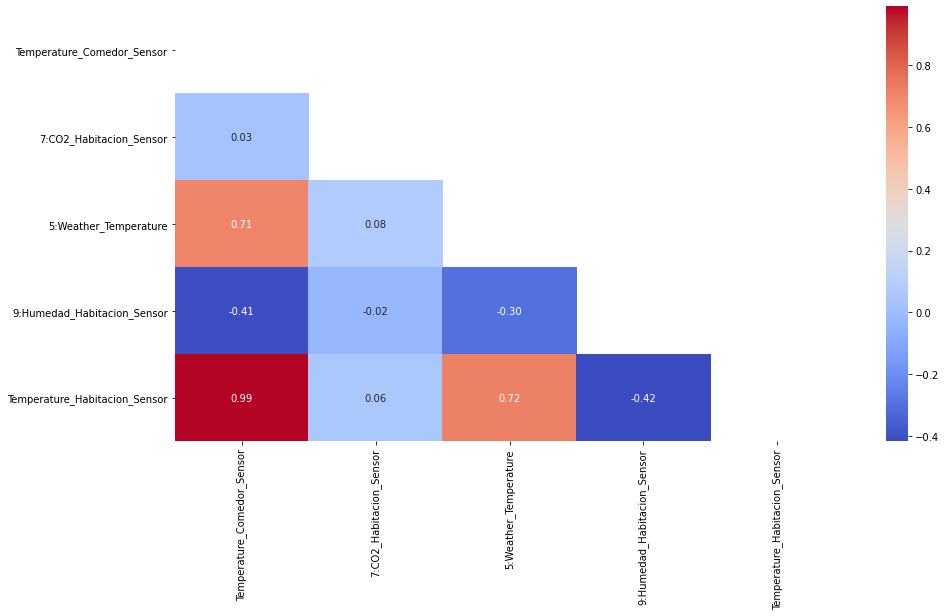

In [ ]:
import seaborn as sns

corr = selected_VSURF_pred.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')